# Objetivo

El objetivo de este notebook de Colab es desarrollar un modelo de machine learning sobre el dataset, a fines de poder predecir valores futuros de la serie temporal elegida, para el proyecto final de la certificación (hackaton)

>15/09/24
>
>Marco Mongi
>
>DS2402

# Importo librerías

In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
from IPython.display import Image

## Cargo el dataset desde drive
Va a pedir acceso a la cuenta de google
Lo siguiente lee un archivo desde drive, y carga el archivo Dataset.csv en el entorno de ejecución

In [5]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link='https://drive.google.com/file/d/1NboG0z-qVZuTx0qKMScZFm0UPJt_Do4_'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('processed_dataset.csv')

In [6]:
link='https://drive.google.com/file/d/1D1RJUQe6lNU85fj-eAAsgM6Cj64ZXB-M'
fluff, id = link.split('d/')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('neural_network.h5')

## Cargo dataset

In [7]:
# Asigno el contenido del csv a un dataframe
df = pd.read_csv('processed_dataset.csv',sep=',')

In [8]:
# Muestro los primeros 20 elementos del dataset (sin procesar)
df.head()

,date,Consumption,hour,day_of_week,month
0,2006-12-16 17:24:00,4.236671,17,5,12
1,2006-12-16 17:25:00,5.377704,17,5,12
2,2006-12-16 17:26:00,5.397025,17,5,12
3,2006-12-16 17:27:00,5.411335,17,5,12
4,2006-12-16 17:28:00,3.703828,17,5,12


In [9]:
df.describe()

,Consumption,hour,day_of_week,month
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.108175e+00,1.150076e+01,2.998909e+00,6.450359e+00
std,1.047192e+00,6.922227e+00,2.000064e+00,3.415762e+00
min,7.600000e-02,0.000000e+00,0.000000e+00,1.000000e+00
25%,3.330165e-01,6.000000e+00,1.000000e+00,3.000000e+00
50%,6.452317e-01,1.200000e+01,3.000000e+00,6.000000e+00
75%,1.538295e+00,1.800000e+01,5.000000e+00,9.000000e+00
max,1.112336e+01,2.300000e+01,6.000000e+00,1.200000e+01


In [10]:
df.dtypes

,0
date,object
Consumption,float64
hour,int64
day_of_week,int64
month,int64


## Proceso dataset

In [11]:
# Cambiamos los tipos de datos para asegurar el manejo adecuado de las columnas
df = df.astype({
    'date': 'datetime64[ns]',  # Fecha y hora exacta de la medición
    'Consumption': float,      # Consumo energético en kW
    'hour': int,               # Hora del día de la medición
    'day_of_week': int,        # Día de la semana
    'month': int               # Mes del año
})

In [12]:
# Resampling
freq='1H'
df=df.resample(freq,on='date').mean()
df.reset_index(inplace=True)

In [13]:
df.set_index('date', inplace=True)

**Columna con medición anterior**

In [14]:
# Armo nueva columna con la medición de consumo en el momento anterior
df['prev_consumption']=df['Consumption'].shift(periods=1)

In [15]:
df.head()

,Consumption,hour,day_of_week,month,prev_consumption
date,,,,,
2006-12-16 17:00:00,4.235039,17.0,5.0,12.0,NaN
2006-12-16 18:00:00,3.633753,18.0,5.0,12.0,4.235039
2006-12-16 19:00:00,3.401852,19.0,5.0,12.0,3.633753
2006-12-16 20:00:00,3.269883,20.0,5.0,12.0,3.401852
2006-12-16 21:00:00,3.058049,21.0,5.0,12.0,3.269883


In [16]:
df = df[1:] # Elimino primera medida (tiene un NaN)

In [17]:
df.head()

,Consumption,hour,day_of_week,month,prev_consumption
date,,,,,
2006-12-16 18:00:00,3.633753,18.0,5.0,12.0,4.235039
2006-12-16 19:00:00,3.401852,19.0,5.0,12.0,3.633753
2006-12-16 20:00:00,3.269883,20.0,5.0,12.0,3.401852
2006-12-16 21:00:00,3.058049,21.0,5.0,12.0,3.269883
2006-12-16 22:00:00,2.202211,22.0,5.0,12.0,3.058049


**Standard Scaler**

In [18]:
# Aplico Standard Scaler
columnas_a_escalar = ['hour', 'day_of_week', 'month', 'prev_consumption']

# Inicializar el StandardScaler
scaler = StandardScaler()

# Ajustar y transformar las columnas seleccionadas
df[columnas_a_escalar] = scaler.fit_transform(df[columnas_a_escalar])

In [19]:
df.head()

,Consumption,hour,day_of_week,month,prev_consumption
date,,,,,
2006-12-16 18:00:00,3.633753,0.938856,1.000528,1.624713,3.520633
2006-12-16 19:00:00,3.401852,1.083316,1.000528,1.624713,2.843618
2006-12-16 20:00:00,3.269883,1.227776,1.000528,1.624713,2.582511
2006-12-16 21:00:00,3.058049,1.372236,1.000528,1.624713,2.433921
2006-12-16 22:00:00,2.202211,1.516696,1.000528,1.624713,2.195408


# Train/Test Split

In [ ]:
# Preparar las variables independientes (X) y dependiente (y)
# X = df[['hour', 'day_of_week', 'month','prev_consumption']].values
# y = df['Consumption'].values

In [ ]:
# Escalar los datos para la red neuronal
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# División de datos en entrenamiento y prueba
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [35]:
def train_test_split_from_date(df, split_date):
    """
    Divide el DataFrame en conjuntos de entrenamiento y prueba en base a una fecha utilizando el índice como fecha.

    Parámetros:
    - df: DataFrame original que contiene las columnas 'hour', 'day_of_week', 'month', y 'Consumption'.
          El índice debe ser una columna datetime.
    - split_date: String que representa la fecha en formato 'YYYY-MM-DD HH:MM:SS'.

    Retorna:
    - X_train: DataFrame con los predictores para el conjunto de entrenamiento.
    - X_test: DataFrame con los predictores para el conjunto de prueba.
    - y_train: Serie con la variable objetivo para el conjunto de entrenamiento.
    - y_test: Serie con la variable objetivo para el conjunto de prueba.
    """
    # Convertir el índice a datetime si no lo está
    df.index = pd.to_datetime(df.index)

    # Dividir el DataFrame en conjunto de entrenamiento y prueba usando el índice
    train = df[df.index < split_date]
    test = df[df.index >= split_date]

    # Definir predictores y variable objetivo
    X_train = train[['hour', 'day_of_week', 'month','prev_consumption']]
    y_train = train['Consumption']
    X_test = test[['hour', 'day_of_week', 'month','prev_consumption']]
    y_test = test['Consumption']

    return X_train, X_test, y_train, y_test

In [36]:
# Realizar el split en base a una fecha
split_date = '2010-01-01 00:00:00'
X_train, X_test, y_train, y_test = train_test_split_from_date(df, split_date)

# Mostrar las formas de los conjuntos de datos resultantes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (26670, 4)
X_test shape: (7918, 4)
y_train shape: (26670,)
y_test shape: (7918,)


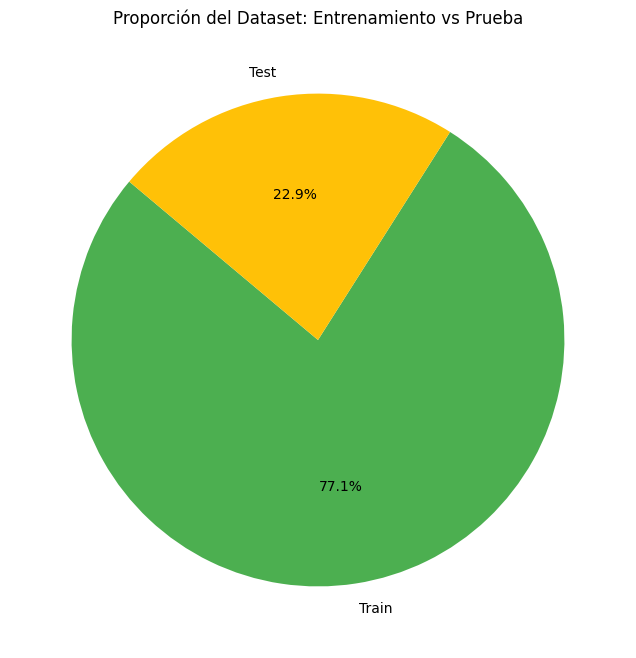

In [37]:
# Calcular los tamaños
size_train = len(X_train)  # Tamaño del conjunto de entrenamiento
size_test = len(X_test)     # Tamaño del conjunto de prueba
total_size = size_train + size_test       # Tamaño total del dataset

# Proporciones para el gráfico
proportions = [size_train / total_size, size_test / total_size]

# Etiquetas para el gráfico
labels = ['Train', 'Test']

# Crear el gráfico de torta
plt.figure(figsize=(8, 8))
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#4CAF50', '#FFC107'])
plt.title('Proporción del Dataset: Entrenamiento vs Prueba')
plt.show()

In [38]:
print("Tamaño dataset original: ", df.shape)
print("Tamaño X_train: ", X_train.shape)
print("Tamaño y_train: ", y_train.shape)

Tamaño dataset original:  (34588, 5)
Tamaño X_train:  (26670, 4)
Tamaño y_train:  (26670,)


# Modelo red neuronal

In [39]:
# Construir el modelo de red neuronal densa
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Salida lineal para regresión

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

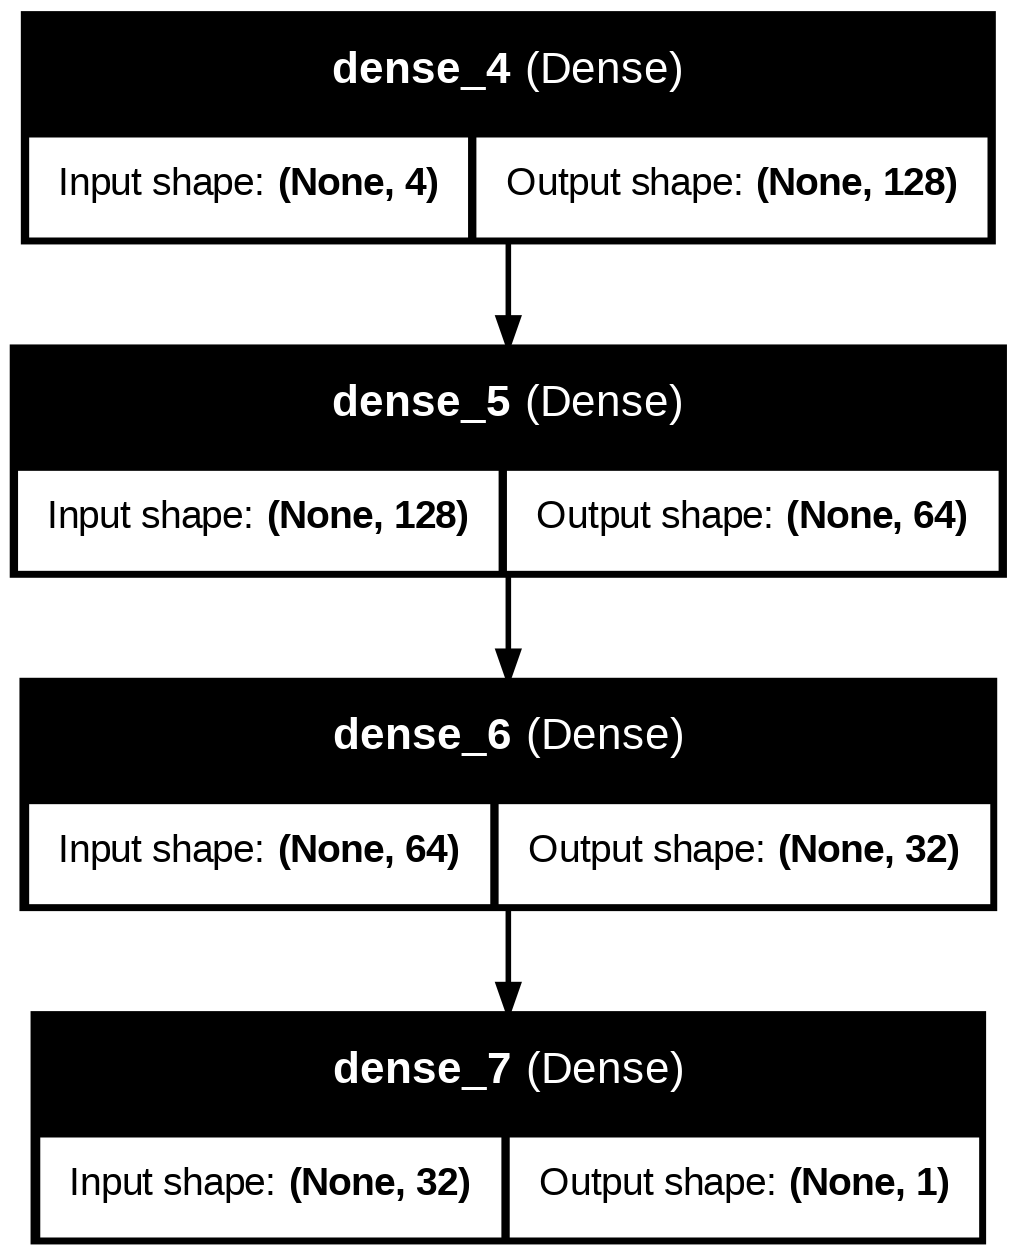

In [41]:
# Asegúrate de que tu modelo esté construido (model.summary() debe funcionar sin errores)
model.summary()

# Generar y guardar la imagen del modelo
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Image('model.png')

# Entrenar el modelo

In [42]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test, y_test), verbose=2)

Epoch 1/100
371/371 - 3s - 7ms/step - loss: 0.4391 - val_loss: 0.2947
Epoch 2/100
371/371 - 1s - 3ms/step - loss: 0.3813 - val_loss: 0.2843
Epoch 3/100
371/371 - 1s - 3ms/step - loss: 0.3734 - val_loss: 0.2798
Epoch 4/100
371/371 - 1s - 2ms/step - loss: 0.3625 - val_loss: 0.2725
Epoch 5/100
371/371 - 1s - 3ms/step - loss: 0.3480 - val_loss: 0.2701
Epoch 6/100
371/371 - 1s - 3ms/step - loss: 0.3350 - val_loss: 0.2569
Epoch 7/100
371/371 - 1s - 3ms/step - loss: 0.3301 - val_loss: 0.2598
Epoch 8/100
371/371 - 1s - 2ms/step - loss: 0.3242 - val_loss: 0.2496
Epoch 9/100
371/371 - 1s - 2ms/step - loss: 0.3216 - val_loss: 0.2501
Epoch 10/100
371/371 - 1s - 3ms/step - loss: 0.3173 - val_loss: 0.2465
Epoch 11/100
371/371 - 1s - 2ms/step - loss: 0.3176 - val_loss: 0.2470
Epoch 12/100
371/371 - 1s - 2ms/step - loss: 0.3142 - val_loss: 0.2468
Epoch 13/100
371/371 - 1s - 2ms/step - loss: 0.3123 - val_loss: 0.2435
Epoch 14/100
371/371 - 2s - 4ms/step - loss: 0.3121 - val_loss: 0.2445
Epoch 15/100
37

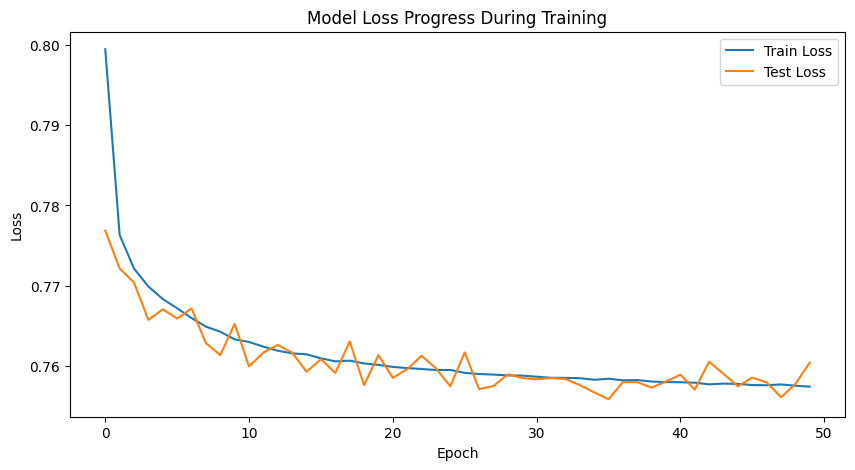

In [ ]:
# Guardo el modelo
#model.save('neural_network.h5')

In [ ]:
# # Cargo el modelo
# from keras import models
# model = models.load_model('neural_network.h5')

## Pruebas con el modelo

In [43]:
# Evaluar el modelo
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Error cuadrático medio (MSE): {mse}")

248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Error cuadrático medio (MSE): 0.25397885271730436


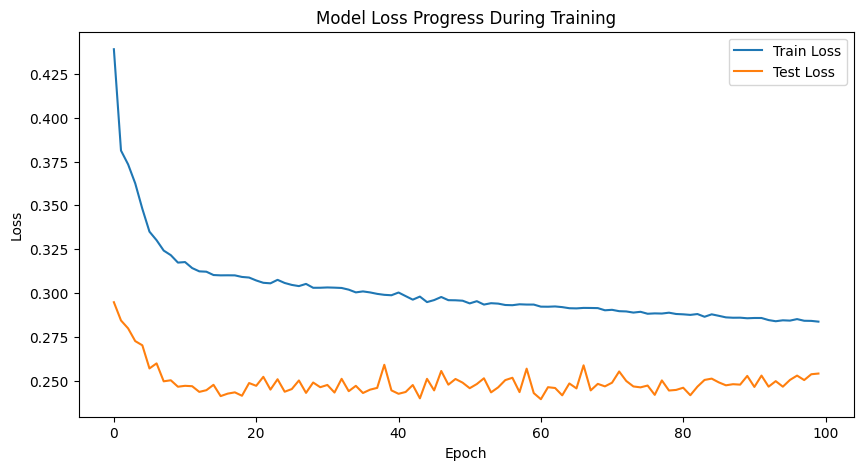

In [44]:
# Graficar la historia de entrenamiento
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Model Loss Progress During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Grafico

In [48]:
def evaluar_modelo(dates, predicted_values, real_values, horizontes):
    """
    Evalúa un modelo de Random Forest (u otro modelo) en diferentes horizontes temporales.

    Parámetros:
    - dates: array con las fechas de las predicciones y valores reales.
    - predicted_values: array con los valores predichos.
    - real_values: array con los valores reales.
    - horizontes: lista de strings que indican los horizontes temporales (por ejemplo, ['1D', '1W', '1M']).

    Retorna:
    - Diccionario con el MSE para cada horizonte.
    """
    resultados = {}

    # Convertir los arrays a DataFrame para manipulación más fácil
    df = pd.DataFrame({
        'ds': pd.to_datetime(dates),
        'pred': predicted_values,
        'real': real_values
    })

    # Definir la fecha de inicio de las predicciones
    inicio_prediccion = df['ds'].iloc[0]

    for horizonte in horizontes:
        # Determinar el delta de tiempo según el horizonte
        if horizonte == '1D':
            delta = pd.Timedelta(days=1)
        elif horizonte == '1W':
            delta = pd.Timedelta(weeks=1)
        elif horizonte == '1M':
            delta = pd.Timedelta(days=30)
        elif horizonte == '3M':
            delta = pd.Timedelta(days=90)
        elif horizonte == '6M':
            delta = pd.Timedelta(days=180)
        elif horizonte == 'test completo':
            delta = df['ds'].iloc[-1] - inicio_prediccion
        else:
            print(f"Horizonte {horizonte} no reconocido.")
            continue

        # Definir el fin del horizonte de predicción
        fin_prediccion = inicio_prediccion + delta

        # Filtrar las predicciones y valores reales para el horizonte actual
        df_horizon = df[(df['ds'] > inicio_prediccion) & (df['ds'] <= fin_prediccion)]

        # Obtener los valores predichos y reales
        predicted = df_horizon['pred']
        actual = df_horizon['real']

        # Calcular el MSE
        mse = mean_squared_error(actual, predicted)
        resultados[horizonte] = mse

        # Graficar los valores predichos y reales
        plt.figure(figsize=(12, 6))
        plt.plot(df_horizon['ds'], actual, label='Valor Real')
        plt.plot(df_horizon['ds'], predicted, label='Predicción')
        plt.xlabel('Fecha')
        plt.ylabel('Consumo de Energía')
        plt.title(f'Predicción vs Real - Horizonte: {horizonte}')
        plt.legend()
        plt.show()

        print(f"MSE para el horizonte {horizonte}: {mse:.4f}")

    return resultados

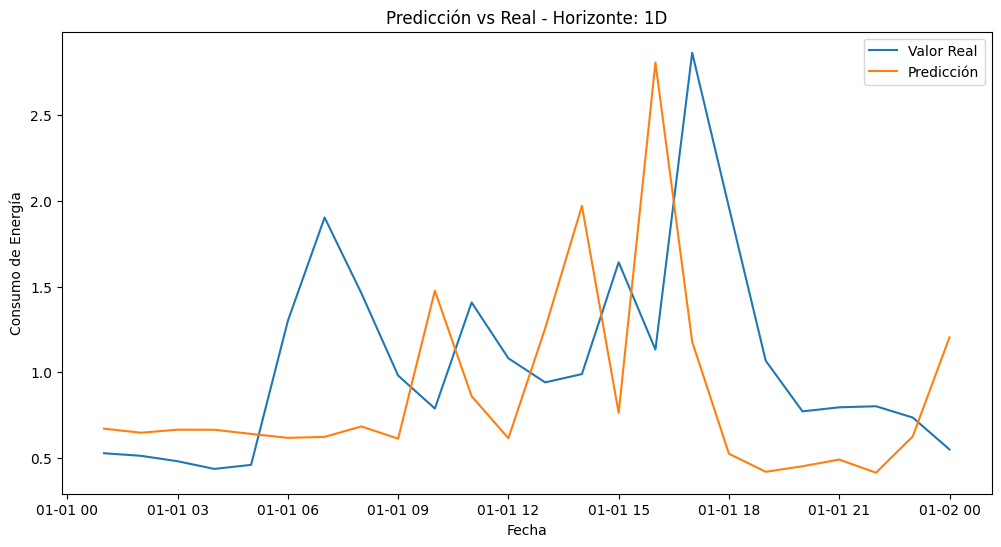

MSE para el horizonte 1D: 0.6138


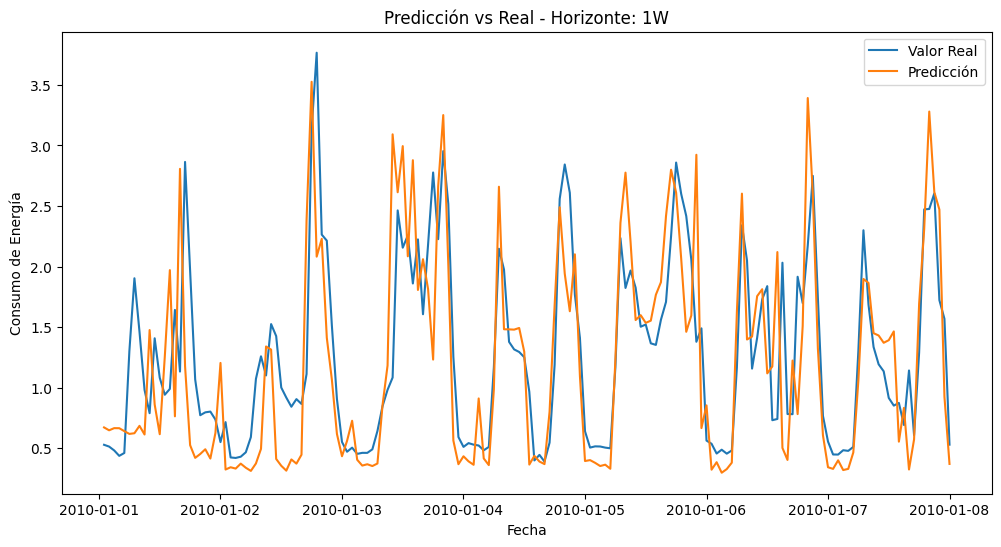

MSE para el horizonte 1W: 0.3433


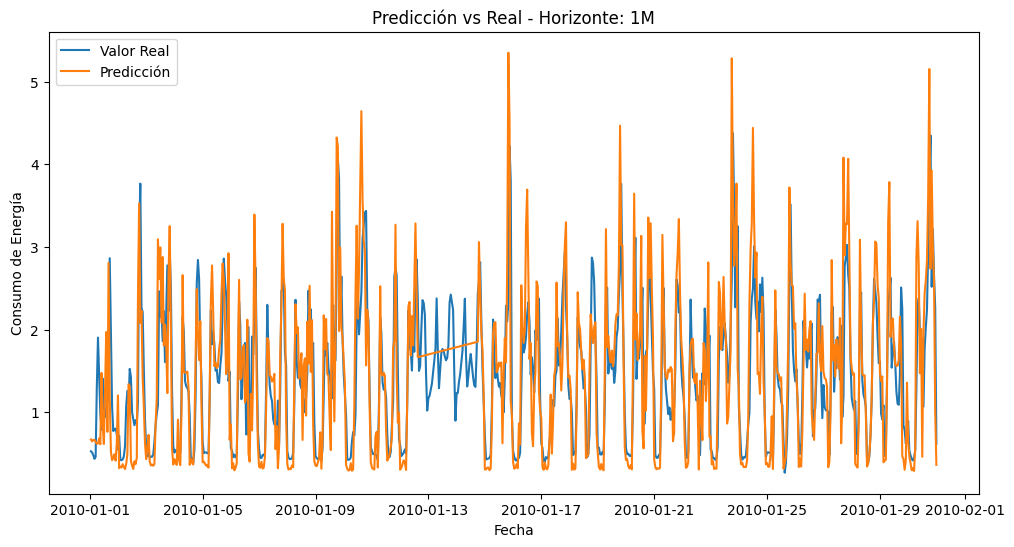

MSE para el horizonte 1M: 0.3666


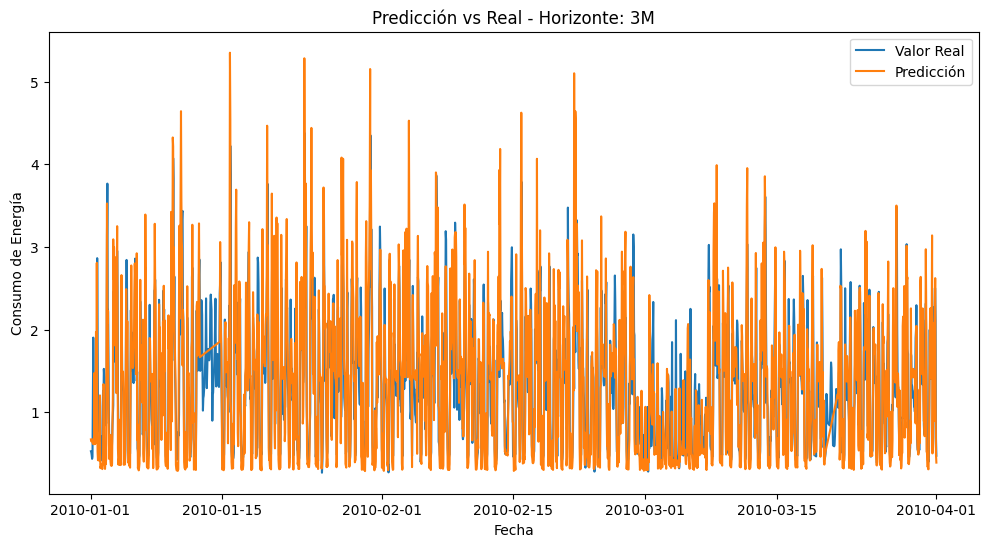

MSE para el horizonte 3M: 0.3086


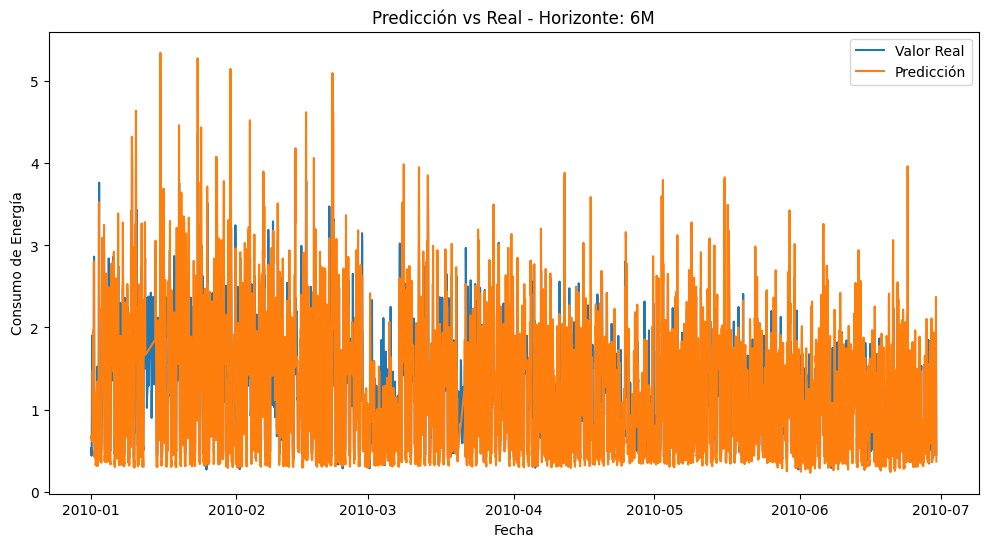

MSE para el horizonte 6M: 0.2791


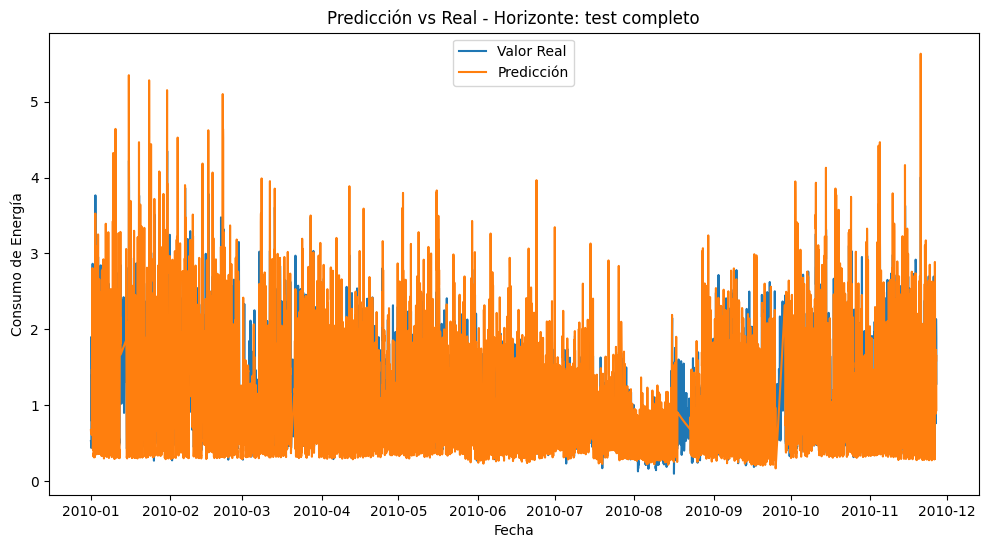

MSE para el horizonte test completo: 0.2540

Resultados de MSE por horizonte:
1D: 0.6138
1W: 0.3433
1M: 0.3666
3M: 0.3086
6M: 0.2791
test completo: 0.2540


In [57]:
dates = y_test.index.values
predicted_values = y_test.values
real_values = predictions[:,0]

# Definir los horizontes temporales que quieres evaluar
horizontes = ['1D', '1W', '1M', '3M', '6M', 'test completo']

# Evaluar el modelo
resultados = evaluar_modelo(dates, predicted_values, real_values, horizontes)

# Mostrar los resultados
print("\nResultados de MSE por horizonte:")
for horizonte, mse in resultados.items():
    print(f"{horizonte}: {mse:.4f}")


# Validar el modelo

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt  # Importamos pyplot para graficar

# Calculamos diferentes métricas de error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
mape = mean_absolute_percentage_error(y_test, predictions)

print(f"Error Cuadrático Medio (MSE): {mse}")
print(f"Error Absoluto Medio (MAE): {mae}")
print(f"Error Porcentual Absoluto Medio (MAPE): {mape}")

Error Cuadrático Medio (MSE): 0.25397885271730436
Error Absoluto Medio (MAE): 0.3513126759171852
Error Porcentual Absoluto Medio (MAPE): 0.4059735270880876


1. **Error Cuadrático Medio (MSE - Mean Squared Error):** El MSE es una medida que eleva al cuadrado las diferencias entre los valores predichos y los reales, lo cual penaliza más los errores grandes. Un MSE de 0.6322725580965985 significa que, en promedio, el cuadrado de los errores de tus predicciones respecto a los valores reales es de aproximadamente 0.63. **Dado que el MSE está en la misma escala que el cuadrado de tu variable objetivo (en este caso, el consumo de energía en kW), puede ser difícil interpretar su magnitud sin contexto**. Un MSE más bajo indica un mejor ajuste del modelo a tus datos.

2. **Error Absoluto Medio (MAE - Mean Absolute Error):** El MAE proporciona una medida de cuán grande es el error en tus predicciones, en promedio. Un MAE de 0.5552547207571173 significa que, **en promedio, tus predicciones se desvían en aproximadamente 0.56 unidades de los valores reales**. A diferencia del MSE, el MAE no eleva al cuadrado los errores, por lo que no penaliza tanto los errores grandes. Es más robusto a outliers y a menudo **más fácil de interpretar, ya que está en la misma unidad que tu variable de predicción**.

3. **Error Porcentual Absoluto Medio (MAPE - Mean Absolute Percentage Error):** El MAPE expresa el error como un porcentaje del valor real y proporciona una visión relativa del error. Un MAPE de 0.8754870291059426 significa que, **en promedio, tus predicciones están fuera por un 87.5% en relación con el valor real**. Este número puede ser engañoso si tienes valores reales que están muy cerca de cero, ya que cualquier pequeño error en la predicción puede resultar en un porcentaje de error muy alto.

Se ve que:


*   El modelo predice valores más bajos que los reales (los residuos son más que nada positivos)
*   Hay diferencias de hasta 7kW



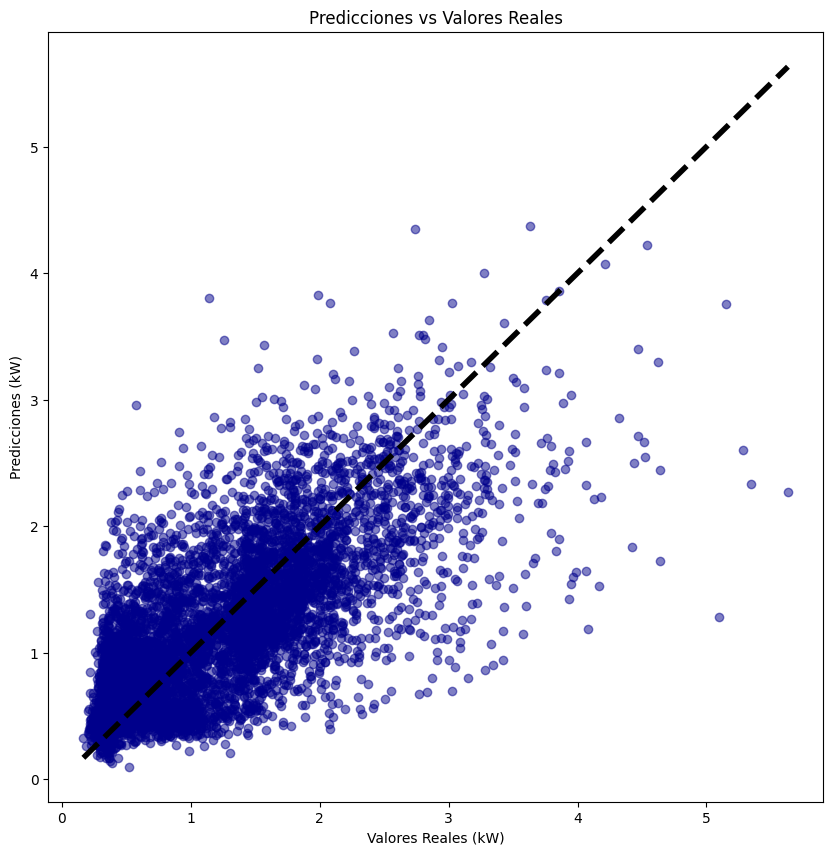

In [59]:
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.5, color='darkblue')
plt.title('Predicciones vs Valores Reales')
plt.xlabel('Valores Reales (kW)')
plt.ylabel('Predicciones (kW)')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

# Importante
Para este modelo, estoy ingresando con el valor del consumo de la medición anterior, por lo que las métricas obtenidas no son independientes y los valores obtenidos no son reales

En un escenario realista, con este modelo podría predecir sólo 1 hora a futuro (ya que para predecir necesito del último valor). Si quisiera evaluar este modelo de forma más realista, debería implementar un pipeline de backpropagation:

1.   Predecir el consumo para la hora siguiente
2.   Escalar ese valor e incluirlo al vector X para predecir dos horas más adelante
3.   Repetir el proceso hasta llegar al momento que quiera predecir

De esta forma, las predicciones más lejanas siempre van a tener una mayor posibilidad de error

